# VISIR count rate calculations

In this notebook we derive the expected count rate for the thermal background and for a source with a known brightness in VISIR. We use the VISIR observation VISIR.2017-04-21T06:06:06.467.fits as reference. The relevant numbers from this observation are quoted below.

* Median background counts: 32000 ADU
* Median counts in dark/masked area: 9000 ADU
* Detector gain in high-gain mode: 15 e/ADU (Ives+ 2012, SPIE proc. Fig. 11a)
* Detector integration time: 11.4 ms (from header)
* Filter: B10.7 (central wavelength: 10.65 micron, half-bandwidth: 1.37 micron, according to VISIR User Manual v97.1, Tab. 1)
* Camera: TMA_SF (small field)
* Detector pixel field of view: 0.045 arcseconds (VISIR User Manual v97.1, sec. 4.1)

This VISIR observation was pointed at the calibration star HD 123139 which has a flux density in the B10.7 micron filter of 49.1 Jy  (Cohen et al. 1999, AJ 117, 1864). The observed count rate of this star is 408000 ADU/DIT in the chop-difference frame. The chop-difference frame is simply the difference between the average of the chop A position and the average of the chop B position, i.e. it also contains ADU/DIT (and not some fraction of it).

In [1]:
from astropy import constants as const
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Expected source count rate / total system transmission

In [2]:
#VLT mirror area (8.2m diameter, 1.1m central obscuration diameter)
VLT_area = np.pi * (4.1*u.m)**2 - np.pi * (0.55*u.m)**2

In [3]:
F_star = 49.1 * u.Jy

In [4]:
# dnu = dlambda * c/lambda**2
bandwidth_nu = 2*1.37*u.micron * const.c/(10.65*u.micron)**2

In [5]:
energy_ph=const.h*const.c/(10*u.micron)

In [6]:
photonrate_star = (F_star * VLT_area * bandwidth_nu/energy_ph).decompose()

In [7]:
# Expected photon rate of the star for 100% system transmission
photonrate_star

<Quantity 9283419926.986786 1 / s>

In [8]:
counts_detected = 408000 # ADU
det_gain = 15 # electrons/ADU
det_dit = 11.4*u.ms
photonrate_detected = (counts_detected * det_gain / det_dit).decompose()

In [9]:
# Detected photon count rate
photonrate_detected

<Quantity 536842105.26315784 1 / s>

In [10]:
# Total system transmission
trans = photonrate_detected/photonrate_star
print("The total system transmission is thus {0:3.2f}%".format(100*trans))

The total system transmission is thus 5.78%


In [11]:
# Let's see if we can understand this transmission
trans_atmo_filter = 0.9 # estimated atmospheric transparency in B10.7 filter (conservative)
trans_telescope = 0.95**2 # two reflections of 0.95 reflectivity each
trans_entrance_window = 0.94 # using ZnSe curve from Roy
trans_foreoptics = 0.5 # out of thin air (conservative)
trans_B107_filter = 0.6 # assumed from the other filter curves in the user manual
qe_aquarius = 0.6 # latest figure from ESO (Derek Ives at detector splinter, METIS CM06)
trans_expected = trans_atmo_filter * trans_telescope * trans_entrance_window * trans_foreoptics * trans_B107_filter * qe_aquarius
print("The total expected transmission is {0:3.2f}%".format(100*trans_expected))
trans_expected_no_atmo = trans_entrance_window * trans_foreoptics * trans_B107_filter * qe_aquarius
print("The expected transmission of VISIR only is {0:3.2f}%".format(100*trans_expected_no_atmo))

The total expected transmission is 13.74%
The expected transmission of VISIR only is 16.92%


### Open question 1: Where does the remaining factor ~ 2.5 in the VLT/VISIR system transmission come from?

Suggestions:
* Transmission of components is lower than assumed
* Gain is larger than assumed

## Background count rate / physical model

### Expected count rate from telescope

In [33]:
# Expected count rate from the two warm mirrors; using average temperature of all VISIR observations from header
emissivity = 0.05 ## assumed emissivity for two warm mirrors
bg_tel_photon_flux = emissivity * (blackbody_lambda(10.65*u.micron,285*u.Kelvin)*(45*u.mas)**2*VLT_area*2.74*u.micron/energy_ph).to("1/s")
print("The expected photon rate from the telescope is {0:.2E} photons/pixel/s".format(bg_tel_photon_flux.value))

The expected photon rate from the telescope is 1.30E+08 photons/pixel/s


### Expected count rate from atmosphere via skycalc model

In [34]:
hdu=fits.open("skytable.fits") # from from http://www.eso.org/observing/etc/bin/simu/skycalc
lam = hdu[1].data["lam"]*u.micron
radiance = hdu[1].data["flux"]/(u.s*u.m**2*u.micron*u.arcsec**2)

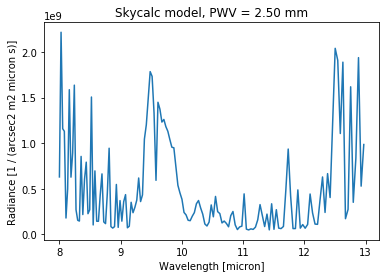

In [35]:
plt.plot(lam,radiance)
plt.xlabel("Wavelength [{0}]".format(lam.unit))
plt.ylabel("Radiance [{0}]".format(radiance.unit))
plt.title("Skycalc model, PWV = 2.50 mm")

In [36]:
# Integrated sky emission in B10.7 filter
filter_edges = [10.65-1.37,10.65+1.37]
bg_atmo_radiance = np.average(radiance.value[(lam.value>filter_edges[0])&(lam.value<filter_edges[1])])
bg_atmo_photon_flux = (bg_atmo_radiance*radiance.unit * (45*u.mas)**2 * VLT_area * np.diff(filter_edges)*u.micron).decompose()[0]
print("The expected background flux from the atmosphere is {0:.2E} photons/pixel/s".format(bg_atmo_photon_flux.value))

The expected background flux from the atmosphere is 1.26E+08 photons/pixel/s


### Total count rate and comparison to observation

In [37]:
# Total count rate
bg_photon_flux = bg_tel_photon_flux + bg_atmo_photon_flux
print("The expected total background flux is {0:.2E} photons/pixel/s".format(bg_photon_flux.value))

The expected total background flux is 2.56E+08 photons/pixel/s


In [38]:
# Convert to expected count rate using calculated total system transmission and Aquarius detector gain
bg_adu = bg_photon_flux*trans/det_gain
print("The expected background count rate is {0:.2E} ADU/pixel/s".format(bg_adu.value))

The expected background count rate is 9.89E+05 ADU/pixel/s


In [39]:
# The observed background rate in the VISIR detector is ca. 32000 - 9000 = 23000 ADU/DIT
adu_bg_total_obs = (23000 / det_dit).decompose()
print("The observed background count rate in VISIR is {0:.2E} ADU/pixel/s".format(adu_bg_total_obs.value))

The observed background count rate in VISIR is 2.02E+06 ADU/pixel/s


### Open question 2: Understand the difference in expected and actual background count rate

The two count rates would match if the emissivity of the two warm mirrors (+ entrance window) were 15% (rather than the assumed 5%)